In [10]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
#from sklearn.metrics import r2_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset¶

In [11]:
data_dir = '../project/archive'
train_path = '../project/archive/Train'
test_path = '../project/archive/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes¶

In [12]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [13]:
# Label Overview
classes = { 0:'Обмеження швидкості (20 км/год)',
            1:'Обмеження швидкості (30 км/год)', 
            2:'Обмеження швидкості (50 км/год)', 
            3:'Обмеження швидкості (60 км/год)', 
            4:'Обмеження швидкості (70 км/год)', 
            5:'Обмеження швидкості (80 км/год)', 
            6:'Кінець обмеження швидкості (80 км/год)', 
            7:'Обмеження швидкості (100 км/год)', 
            8:'Обмеження швидкості (120 км/год)', 
            9:'Проїзд заборонений', 
            10:'Проїзд транспортних засобів понад 3,5 тонни заборонено', 
            11:'Перехрещення з другорядною дорогою', 
            12:'Головна дорога', 
            13:'Дати дорогу', 
            14:'Проїзд без зупинки заборонено', 
            15:'Рух заборонено', 
            16:'Рух вантажних автомобілів заборонено', 
            17:'В’їзд заборонено', 
            18:'Аварійно небезпечна ділянка (інша небезпека)', 
            19:'Небезпечний поворот ліворуч', 
            20:'Небезпечний поворот праворуч', 
            21:'Декілька поворотів', 
            22:'Нерівна дорога', 
            23:'Слизька дорога', 
            24:'Звуження дороги з правого боку', 
            25:'Дорожні роботи', 
            26:'Світлофорне регулювання', 
            27:'Пішоходи', 
            28:'Діти', 
            29:'Виїзд велосипедистів', 
            30:'Остерігайтеся льоду або снігу',
            31:'Дикі тварини', 
            32:'Кінець усіх заборон і обмежень', 
            33:'Рух праворуч', 
            34:'Рух ліворуч', 
            35:'Рух тільки прямо', 
            36:'Рух прямо або праворуч', 
            37:'Рух прямо або ліворуч', 
            38:'Об’їзд перешкоди з правого боку', 
            39:'Об’їзд перешкоди з лівого боку', 
            40:'Круговий рух', 
            41:'Кінець заборони обгону', 
            42:'Кінець заборони обгону вантажним автомобілям' }

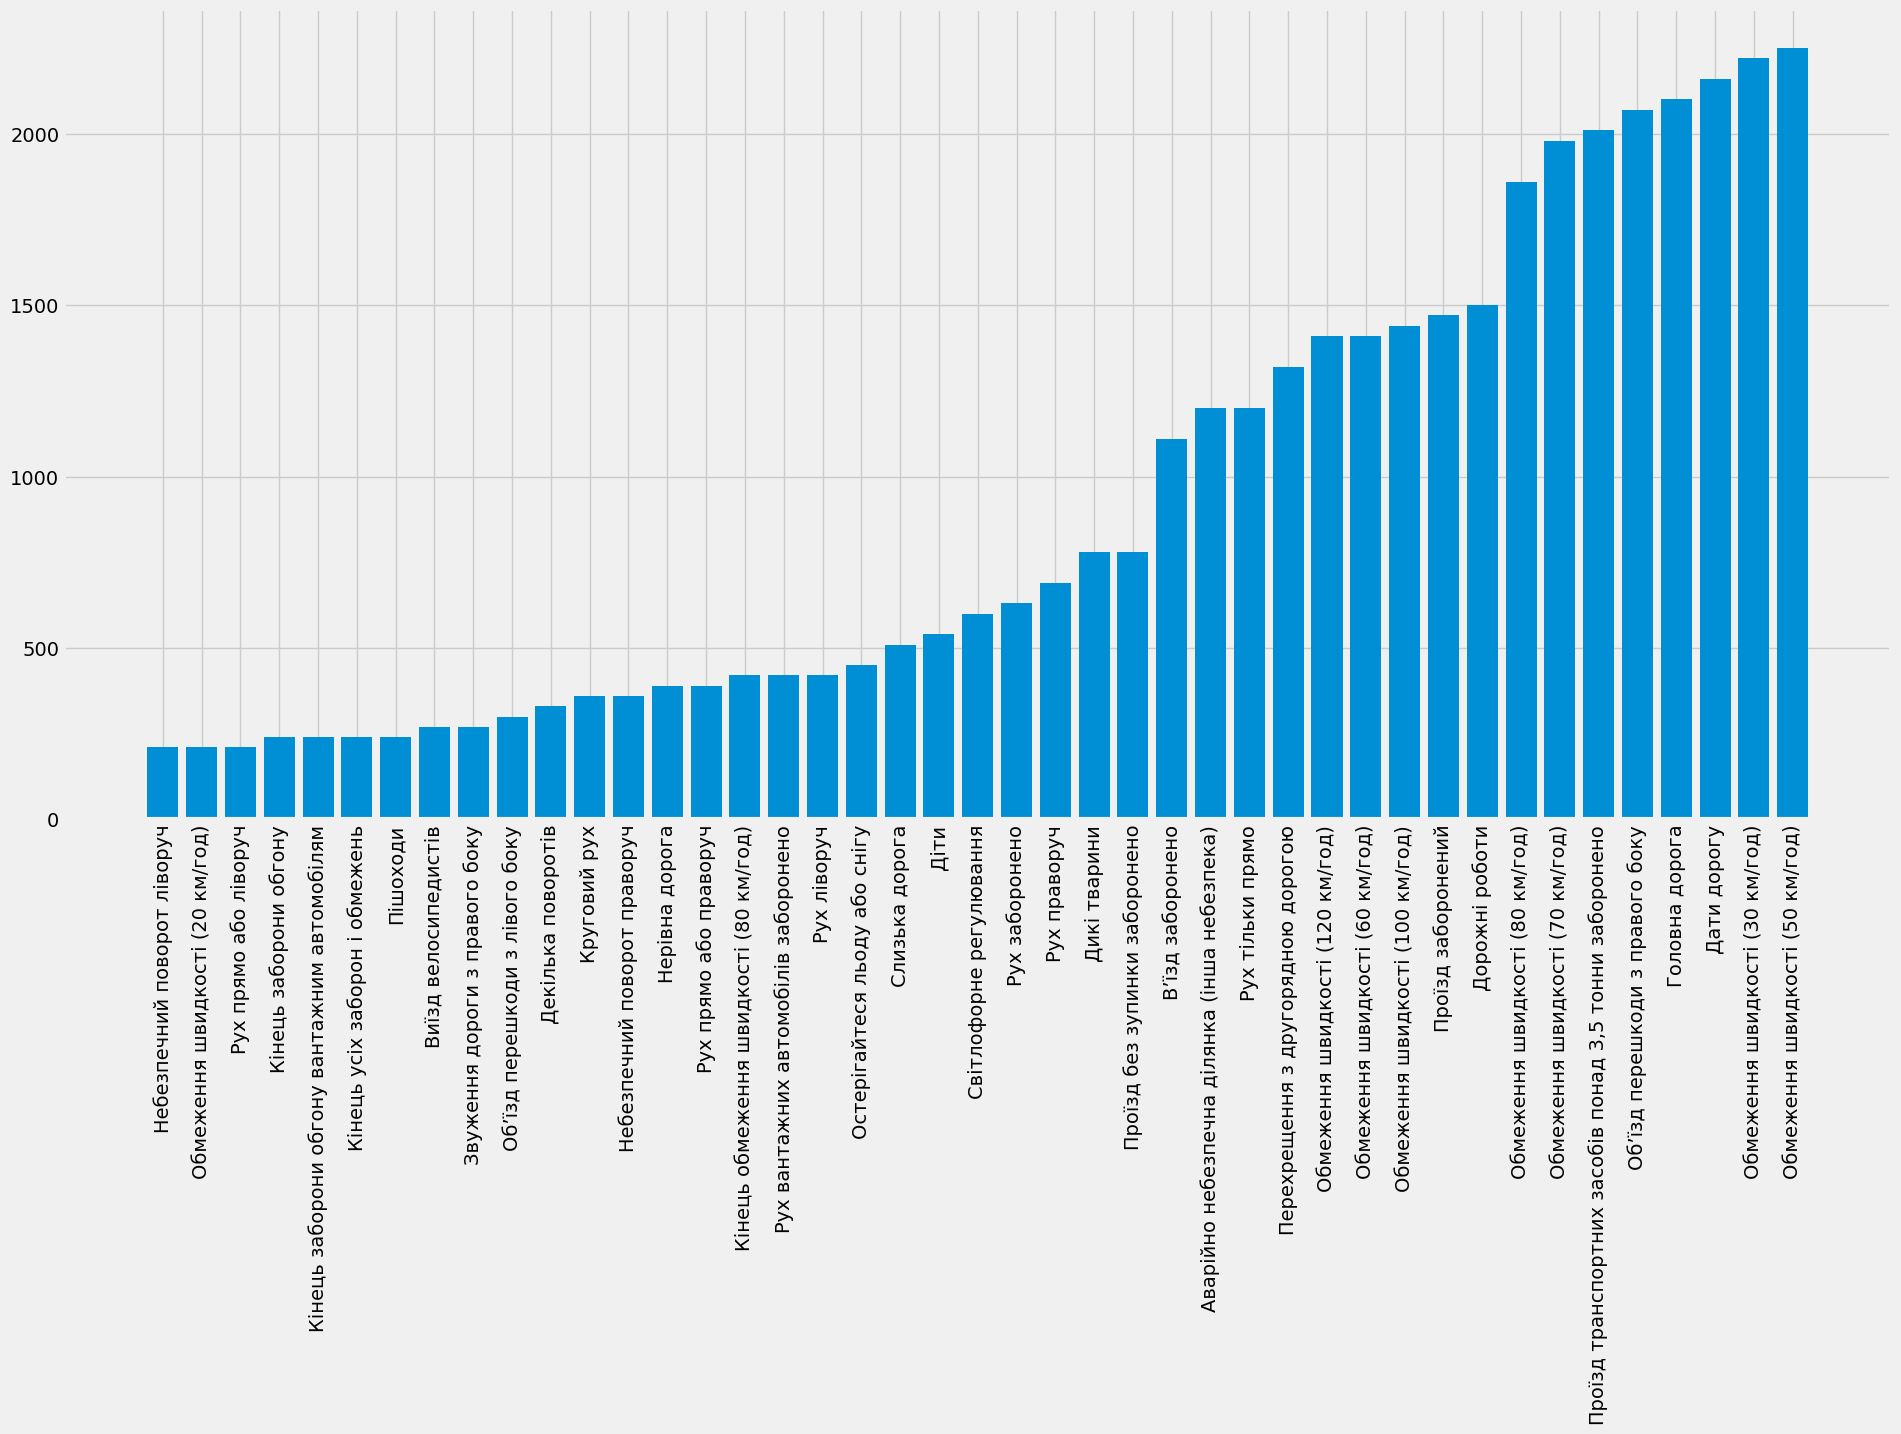

In [14]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

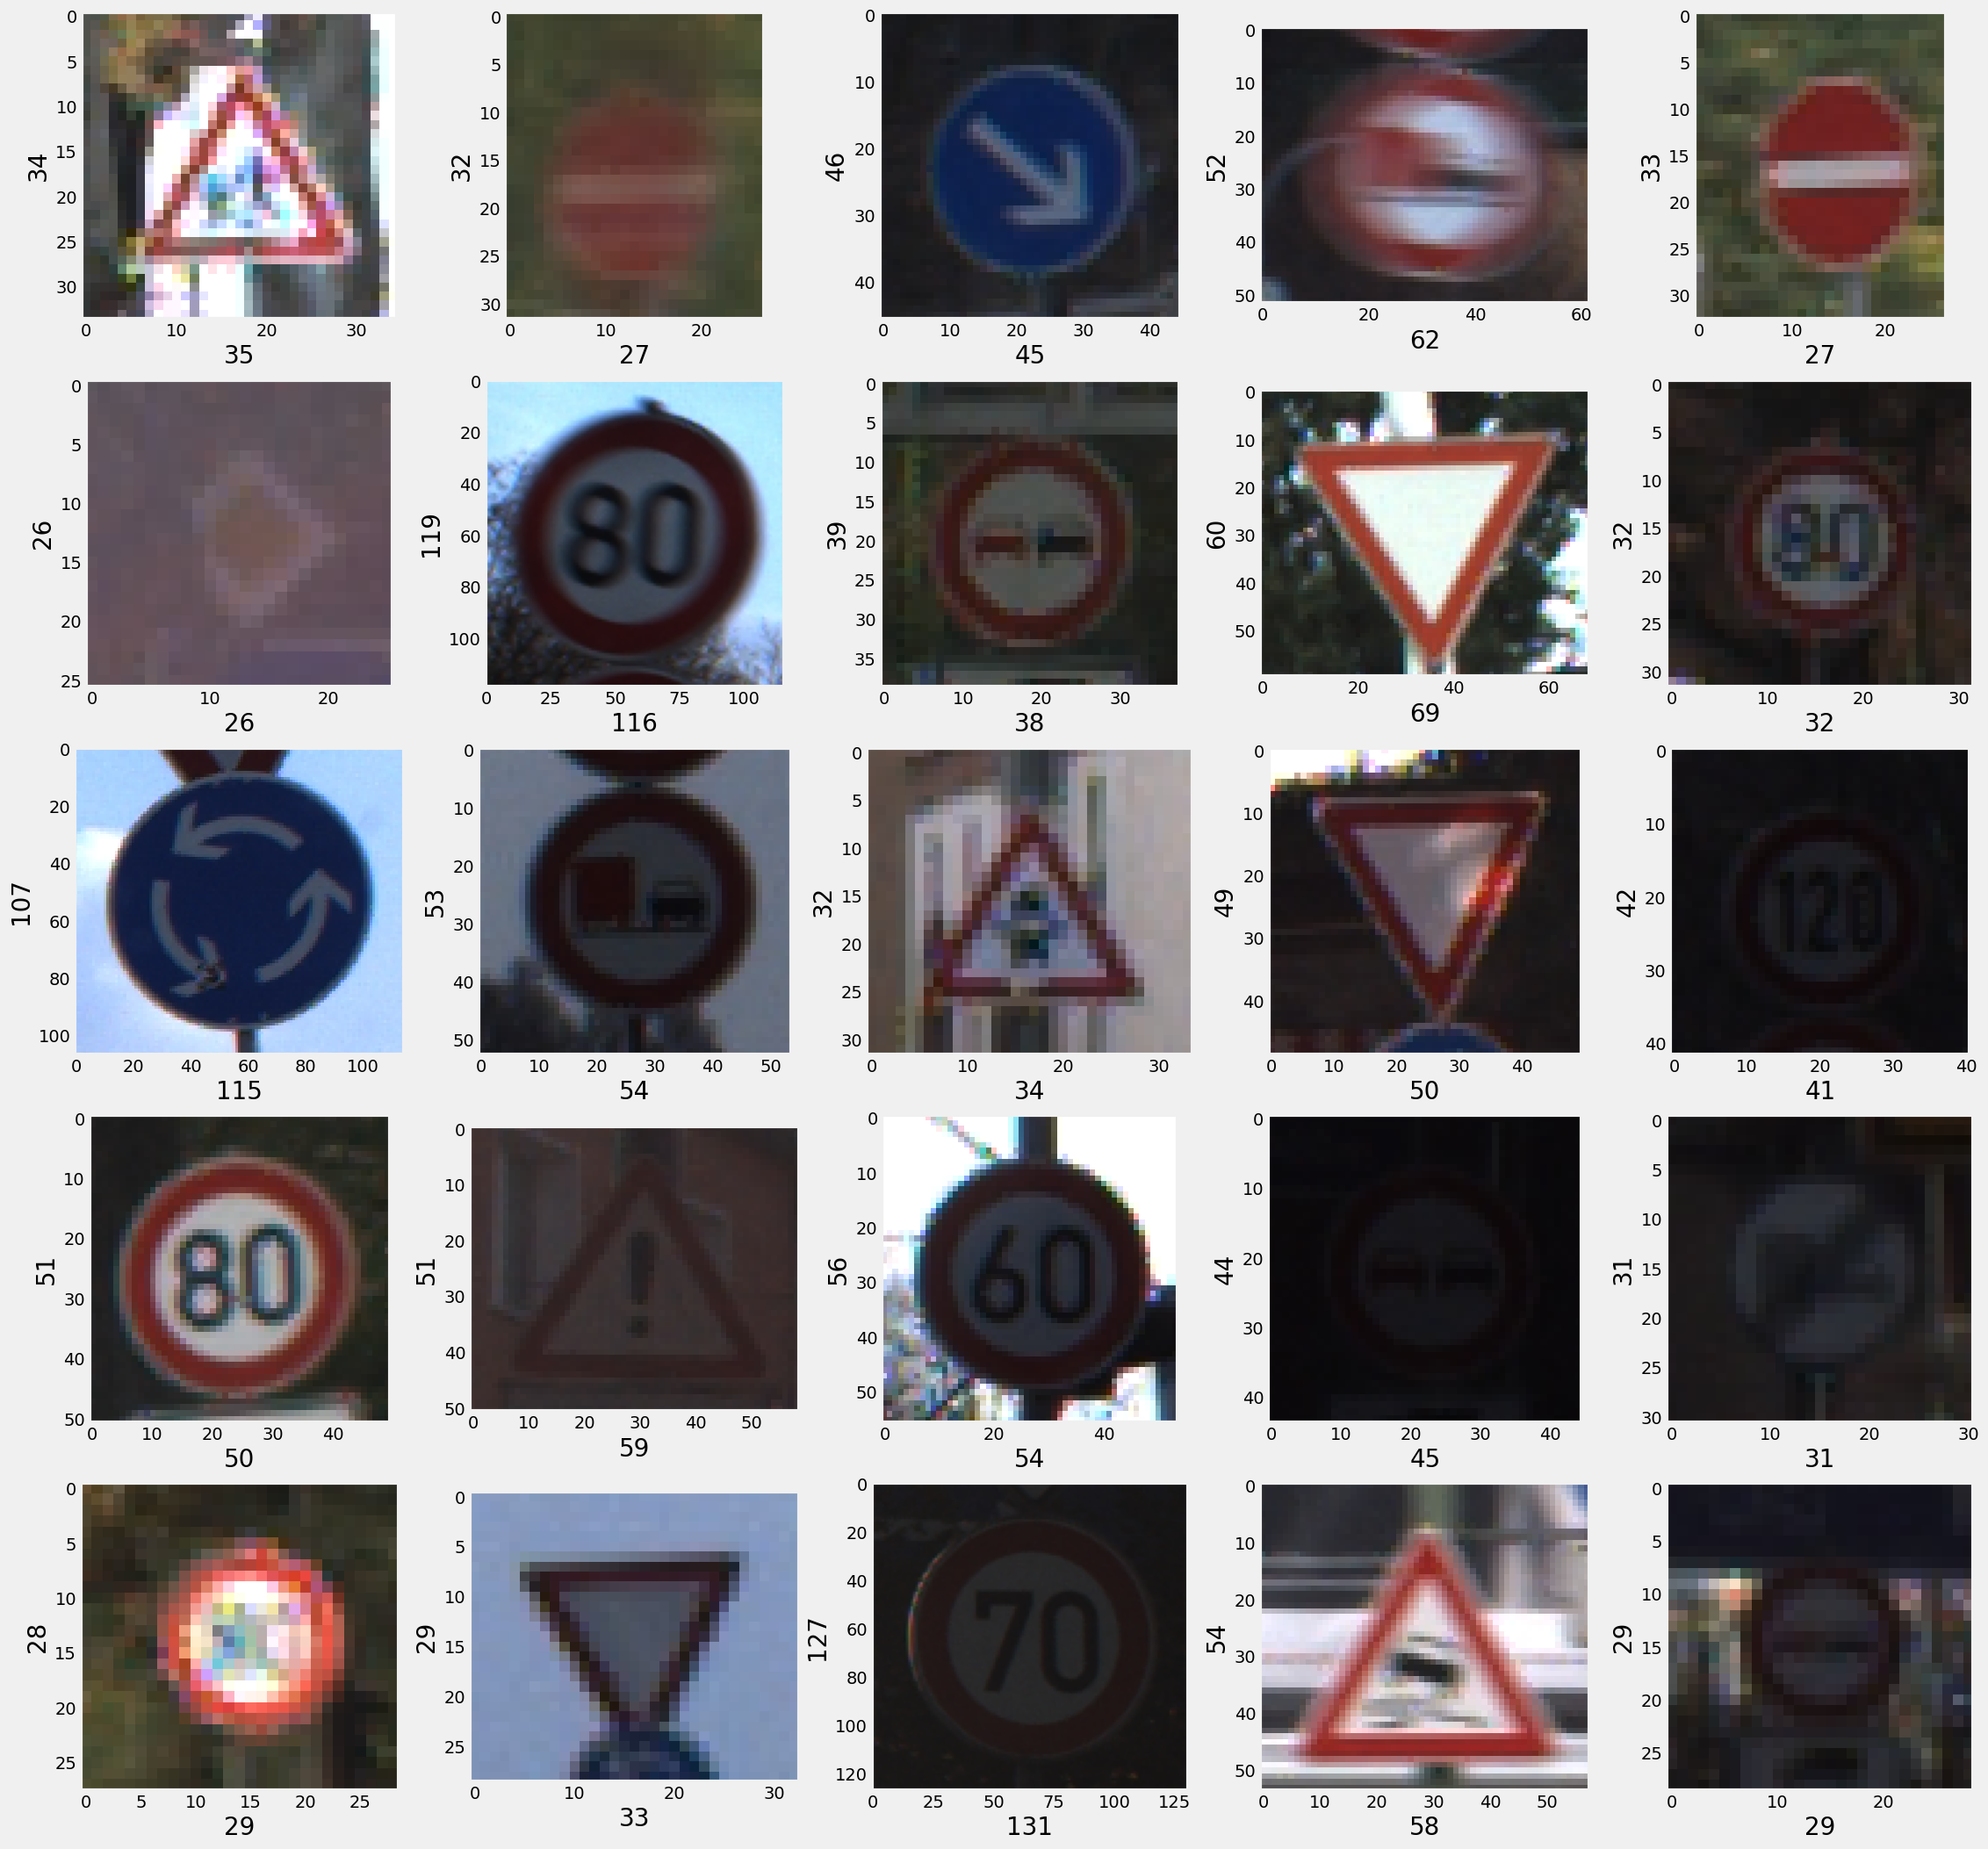

In [15]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [16]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [17]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [18]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [19]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [40]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])


In [41]:
epochs = 10
lr = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps=10000,
    decay_rate=lr / (30 * 0.5))
    
opt = Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [42]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/10
858/858 [==============================] - 33s 36ms/step - loss: 1.0738 - accuracy: 0.7083 - val_loss: 0.0946 - val_accuracy: 0.9743
Epoch 2/10
858/858 [==============================] - 31s 36ms/step - loss: 0.2025 - accuracy: 0.9407 - val_loss: 0.0201 - val_accuracy: 0.9957
Epoch 3/10
858/858 [==============================] - 31s 36ms/step - loss: 0.1152 - accuracy: 0.9666 - val_loss: 0.0136 - val_accuracy: 0.9969
Epoch 4/10
858/858 [==============================] - 31s 36ms/step - loss: 0.0872 - accuracy: 0.9743 - val_loss: 0.0105 - val_accuracy: 0.9973
Epoch 5/10
858/858 [==============================] - 30s 35ms/step - loss: 0.0713 - accuracy: 0.9798 - val_loss: 0.0088 - val_accuracy: 0.9981
Epoch 6/10
858/858 [==============================] - 30s 35ms/step - loss: 0.0663 - accuracy: 0.9816 - val_loss: 0.0081 - val_accuracy: 0.9979
Epoch 7/10
858/858 [==============================] - 30s 35ms/step - loss: 0.0615 - accuracy: 0.9834 - val_loss: 0.0081 - val_accuracy:

## Evaluating the model

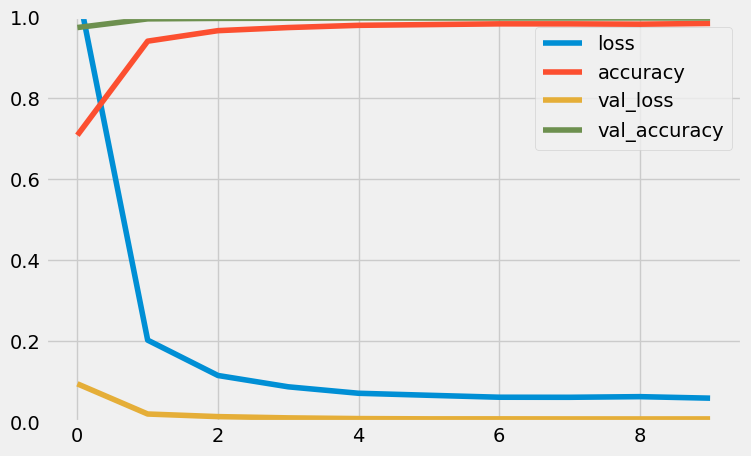

In [43]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [25]:
from sklearn.metrics import mean_squared_error

In [45]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)



#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, predict_x)*100)

395/395 [==============================] - 4s 9ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [46]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)



#Accuracy with the test data
print('Test Data accuracy: ',mean_squared_error(labels, predict_x)*100)

395/395 [==============================] - 4s 9ms/step


ValueError: y_true and y_pred have different number of output (1!=43)